<a href="https://colab.research.google.com/github/jegazhu/python-projects/blob/main/Time_Series_Forecasting_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [183]:
df = pd.read_csv('/content/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

#df = pd.read_csv('/content/PJM_Load_hourly.csv', index_col='Datetime', parse_dates=True)
#df.index = pd.to_datetime(df.index)
#df.head()

In [184]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [185]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


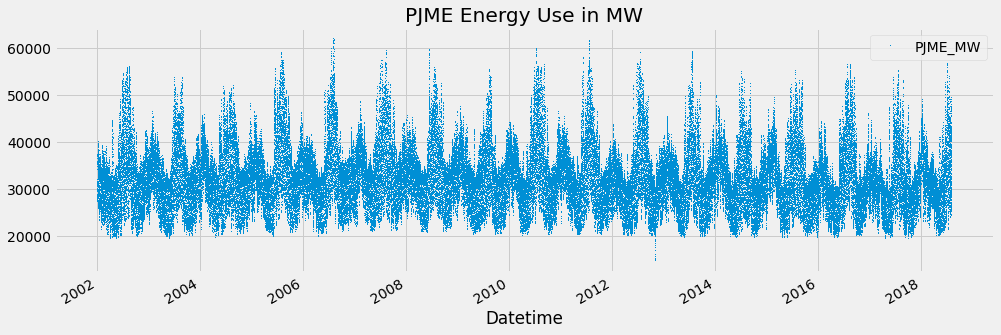

In [186]:
df.plot(style=',', figsize=(15, 5), color=color_pal[0], title='PJME Energy Use in MW')
plt.show()

In [187]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [188]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# **Splitting our Test**

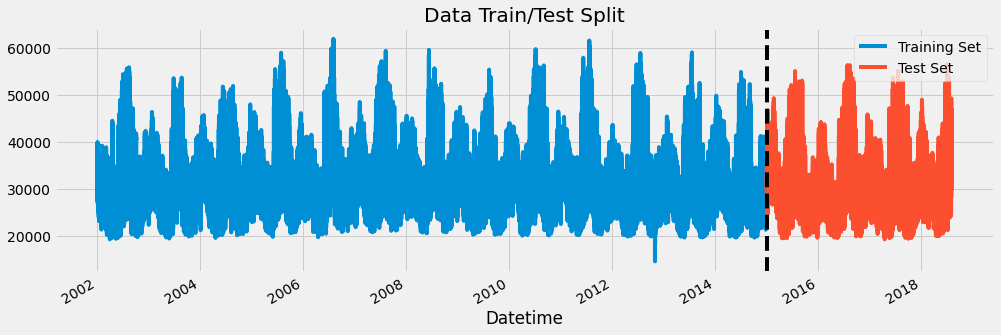

In [189]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

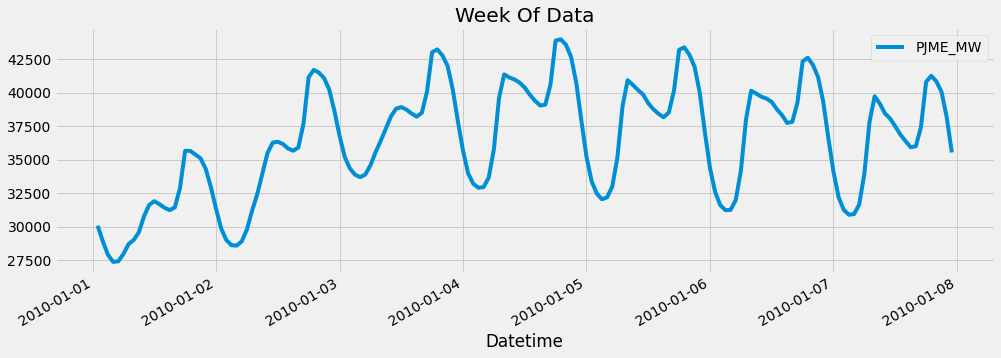

In [190]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [191]:
df.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='Datetime', length=145366)

In [192]:
def create_features(df):
    """
    Creating time series features according to time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# **Visualizing Feature and Target**

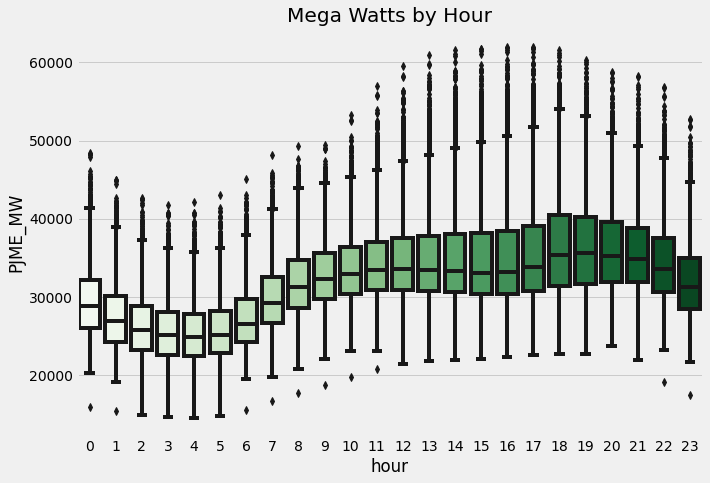

In [193]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Greens')
ax.set_title('Mega Watts by Hour')
plt.show()

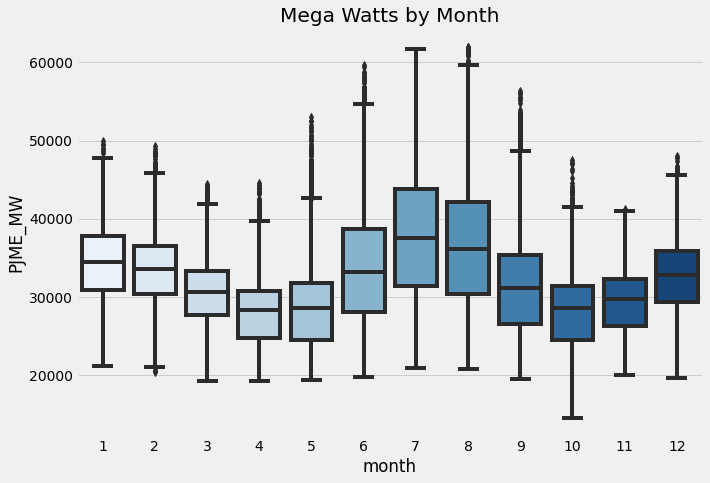

In [194]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('Mega Watts by Month')
plt.show()

# **Modeling**

In [195]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [196]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, 
                       learning_rate=0.01)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.1	validation_1-rmse:31657.1
[100]	validation_0-rmse:12581.2	validation_1-rmse:11743.7
[200]	validation_0-rmse:5835.05	validation_1-rmse:5365.67
[300]	validation_0-rmse:3915.7	validation_1-rmse:4020.66
[400]	validation_0-rmse:3443.11	validation_1-rmse:3853.4
[500]	validation_0-rmse:3285.31	validation_1-rmse:3805.31
[600]	validation_0-rmse:3201.91	validation_1-rmse:3772.44
[700]	validation_0-rmse:3148.12	validation_1-rmse:3750.92
[800]	validation_0-rmse:3109.22	validation_1-rmse:3733.9
[900]	validation_0-rmse:3079.37	validation_1-rmse:3725.61
[999]	validation_0-rmse:3052.71	validation_1-rmse:3722.92


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

In [197]:
reg.feature_importances_

array([0.11356887, 0.28172204, 0.15294188, 0.05881388, 0.3699627 ,
       0.02299066], dtype=float32)

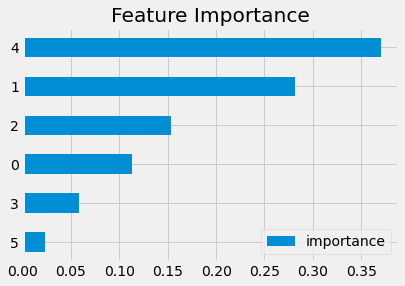

In [199]:
fi = pd.DataFrame(data = reg.feature_importances_ ,
             #index = reg.feature_names_in_ ,
             columns = ['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

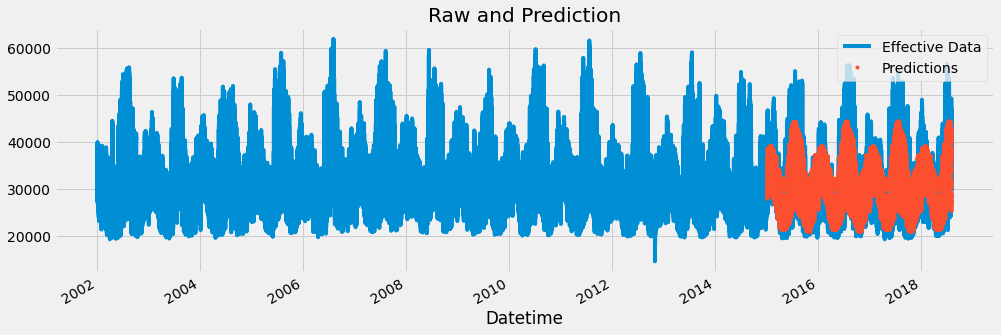

In [200]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Effective Data', 'Predictions'])
ax.set_title('Raw and Prediction')
plt.show()

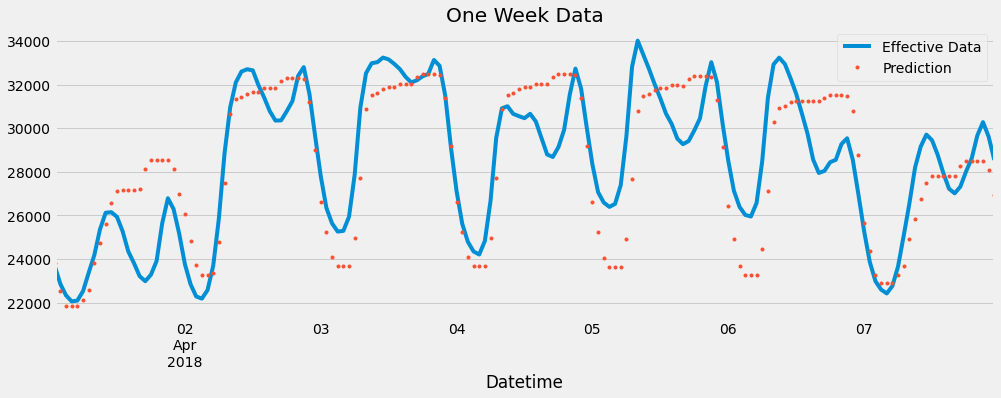

In [201]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='One Week Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Effective Data','Prediction'])
plt.show()

In [202]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'***RMSE Score on Test set: {score:0.2f}***')

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

***RMSE Score on Test set: 3722.92***


date
2016-08-13    12853.568034
2016-08-14    12796.636312
2016-09-10    11369.115804
2015-02-20    10931.238200
2016-09-09    10877.764323
2018-01-06    10475.434652
2016-08-12    10138.022217
2015-02-21     9847.064046
2015-02-16     9753.021729
2018-01-07     9710.187581
Name: error, dtype: float64